In [1]:
# Running on GPU?
import setGPU

import getpass
import h5py
import os
import pickle
import matplotlib.pyplot as plt

from tqdm import tqdm

setGPU: Setting GPU to: 0


In [2]:
# Get permission to access EOS (Insert your NICE password)
os.system("echo %s | kinit" % getpass.getpass())

KeyboardInterrupt: 

In [ ]:
import json
import numpy as np
import pandas as pd

import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Dense, Lambda, BatchNormalization
from keras.layers.advanced_activations import PReLU
from keras.activations import sigmoid, linear, relu
from keras.models import Model, load_model
from keras.regularizers import l1, l2, l1_l2

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

In [ ]:
PDs  = {1: 'BTagCSV',
        2: 'BTagMu',
        3: 'Charmonium',
        4: 'DisplacedJet',
        5: 'DoubleEG',
        6: 'DoubleMuon',
        7: 'DoubleMuonLowMass',
        8: 'FSQJets',
        9: 'HighMultiplicityEOF',
        10: 'HTMHT',
        11: 'JetHT',
        12: 'MET',
        13: 'MinimumBias',
        14: 'MuonEG',
        15: 'MuOnia',
        16: 'NoBPTX',
        17: 'SingleElectron',
        18: 'SingleMuon',
        19: 'SinglePhoton',
        20: 'Tau',
        21: 'ZeroBias'}

# Select PD
nPD = 11

In [ ]:
data_directory = "/eos/cms/store/user/fsiroky/consistentlumih5/"
label_file = "/afs/cern.ch/user/t/tkrzyzek/Documents/Data-Certification/JetHT.json"
model_directory = "/eos/user/t/tkrzyzek/autoencoder/batch_norm/"
model_name = "model"

In [ ]:
def get_file_list(directory, pds, npd, typeof, extension):
    files = []
    parts = ["C", "D", "E", "F", "G", "H"]
    for p in parts:
        files.append("%s%s_%s_%s%s" % (directory, pds[npd], p, typeof, extension))
    return files

files = get_file_list(data_directory, PDs, nPD, "background", ".h5")
files = files + get_file_list(data_directory, PDs, nPD, "signal", ".h5")

In [ ]:
# Load good and bad jets
def get_data(files):
    readout = np.empty([0,2813])
    
    for file in files:
        jet = file.split("/")[-1][:-3]
        print("Reading: %s" % jet)
        try:
            h5file = h5py.File(file, "r")
            readout = np.concatenate((readout, h5file[jet][:]), axis=0)
        except OSError as error:
            print("This Primary Dataset doesn't have %s. %s" % (jet, error))
            continue

    return readout

data = pd.DataFrame(get_data(files))

In [ ]:
data["run"] = data[2807].astype(int)
data["lumi"] = data[2808].astype(int)
data["inst_lumi"] = data[2809].astype(float)

# Drop unnecessary meta data
data.drop([2807, 2808, 2809, 2810, 2811, 2812], axis=1, inplace=True)

# Sort by runID and then by lumiID
data = data.sort_values(["run", "lumi"], ascending=[True,True])

# Reset index
data = data.reset_index(drop=True)  

runIDs  = data["run"].astype(int)
lumiIDs = data["lumi"].astype(int)
luminosity = data["inst_lumi"].astype(float)

In [ ]:
# Apply labels
output_json = json.load(open(label_file))

def json_checker(json_file, orig_runid, orig_lumid):
    try:
        for i in json_file[str(int(orig_runid))]:
            if orig_lumid >= i[0] and orig_lumid <= i[1]:
                return 0
    except KeyError:
        pass
    return 1

def add_flags(sample):
    return json_checker(output_json, sample["run"], sample["lumi"])

data["label"] = data.apply(add_flags, axis=1)

In [10]:
# treshold = 4e7
# plt.rcParams['figure.figsize'] = [40, 20]
# plt.hist(data.iloc[:, :2807].values.reshape(-1), bins=1000)
# plt.xscale('log')
# plt.yscale('log')
# plt.axvline(treshold, color='r')
# plt.ylabel("Feature value")
# plt.xlabel("Number of feature values")
# plt.title("Histogram of all feature values of all lumisections")
# plt.show()

In [11]:
# data['keep'] = data.apply(lambda row: all([x < treshold for x in row]), axis = 1)

In [12]:
# data[data['keep'] == False].shape

In [12]:
data_orig = data

In [13]:
# Split the data
SPLIT_FACTOR = 0.1

split = round(SPLIT_FACTOR*len(data))

runIDs = runIDs[split:]
lumiIDs = lumiIDs[split:]
luminosity = luminosity[split:]

train = data.iloc[:split]
print("Before:", train.shape)
# train = train[train['keep'] == True]
print("After:", train.shape)
X_train = train.iloc[:, 0:2806]
y_train = train["label"]

test = data.iloc[split:]
X_test = test.iloc[:, 0:2806]
y_test = test["label"]

normalizer = StandardScaler()
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

# Train only on good
X_train = X_train[y_train == 0]
X_train_norm = X_train_norm[y_train == 0]

input_dim = X_train.shape[1]

Before: (16368, 2811)
After: (16368, 2811)


In [19]:
input_layer = Input(shape=(input_dim, ))

x = BatchNormalization()(input_layer)
x = Dense(2000, kernel_regularizer=l1_l2(10e-5))(x)
x = PReLU()(x)

x = BatchNormalization()(x)
x = Dense(1000, kernel_regularizer=l1_l2(10e-5))(x)
x = PReLU()(x)

x = BatchNormalization()(x)
x = Dense(500, kernel_regularizer=l1_l2(10e-5))(x)
x = PReLU()(x)

x = BatchNormalization()(x)
x = Dense(1000, kernel_regularizer=l1_l2(10e-5))(x)
x = PReLU()(x)

x = BatchNormalization()(x)
x = Dense(2000, kernel_regularizer=l1_l2(10e-5))(x)
x = PReLU()(x)

x = BatchNormalization()(x)
x = Dense(input_dim)(x)
x = linear(x)

autoencoder = Model(inputs=input_layer, outputs=x)

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 2806)              0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 2806)              11224     
_________________________________________________________________
dense_7 (Dense)              (None, 2000)              5614000   
_________________________________________________________________
p_re_lu_6 (PReLU)            (None, 2000)              2000      
_________________________________________________________________
batch_normalization_10 (Batc (None, 2000)              8000      
_________________________________________________________________
dense_8 (Dense)              (None, 1000)              2001000   
_________________________________________________________________
p_re_lu_7 (PReLU)            (None, 1000)              1000      
__________

In [17]:
X_train = X_train.values
X_test = X_test.values

In [18]:
input_layer = Input(shape=(input_dim, ))

x = BatchNormalization()(input_layer)

norm_model = Model(inputs=input_layer, outputs=x)

norm_model.summary()

adamm = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

norm_model.compile(optimizer=adamm, loss='mean_squared_error')

X_train_minibatch_norm = norm_model.predict(X_train)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 2806)              0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 2806)              11224     
Total params: 11,224
Trainable params: 5,612
Non-trainable params: 5,612
_________________________________________________________________


In [20]:
adamm = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

early_stopper = EarlyStopping(monitor="val_loss",
                              patience=32,
                              verbose=True,
                              mode="auto")

autoencoder.compile(optimizer=adamm, loss='mean_squared_error')

checkpoint_callback = ModelCheckpoint(("%s%s.h5" % (model_directory, model_name)),
                                      monitor="val_loss",
                                      verbose=False,
                                      save_best_only=True,
                                      mode="min")

In [21]:
autoencoder.fit(X_train,
                X_train_minibatch_norm,
                epochs=64,
                batch_size=256,
                validation_split=0.25,
                verbose=2,
                callbacks=[early_stopper, checkpoint_callback])

Train on 11859 samples, validate on 3954 samples
Epoch 1/64
41s - loss: 3435161384.5134 - val_loss: 443383402.8366
Epoch 2/64
27s - loss: 3435149664.3211 - val_loss: 443377041.0197
Epoch 3/64
31s - loss: 3435141703.7582 - val_loss: 443369328.0567
Epoch 4/64
37s - loss: 3435136843.1394 - val_loss: 443362455.9150
Epoch 5/64
30s - loss: 3435132248.7333 - val_loss: 443356242.5979
Epoch 6/64
29s - loss: 3435122420.5656 - val_loss: 443355990.9277
Epoch 7/64
2s - loss: 3435116005.0809 - val_loss: 443357456.9631
Epoch 8/64
2s - loss: 3435104281.7863 - val_loss: 443359880.0931
Epoch 9/64
2s - loss: 3435091054.4866 - val_loss: 443368030.0253
Epoch 10/64
2s - loss: 3435083410.3058 - val_loss: 443368391.0086
Epoch 11/64
2s - loss: 3435072814.2663 - val_loss: 443368279.2514
Epoch 12/64
2s - loss: 3435064270.7854 - val_loss: 443363350.1345
Epoch 13/64
2s - loss: 3435050981.7562 - val_loss: 443356809.4284
Epoch 14/64
28s - loss: 3435039983.1922 - val_loss: 443354669.1512
Epoch 15/64
32s - loss: 34350

In [22]:
# Reload saved model
autoencoder = load_model("%s%s.h5" % (model_directory, model_name))

In [23]:
# Run predictions
predictions = autoencoder.predict(X_test)

def get_error_df(X_test, predictions, mode="allmean", n_highest = 100):
    
    if mode == "allmean":
        return np.mean(np.power(X_test - predictions, 2), axis=1)
    
    elif mode == "topn":
        temp = np.partition(-np.power(X_test - predictions, 2), n_highest)
        result = -temp[:,:n_highest]
        return np.mean(result, axis=1)
    
    elif mode == "perobj":
        mses = []
        for l in legend:
            mse = np.mean(
                np.power(X_test[:,l["start"]:l["end"]] - predictions[:,l["start"]:l["end"]], 2),
                axis=1)
            mses.append(mse)
     
        return np.maximum.reduce(mses)
    
ae_error = get_error_df(X_test, predictions, mode="topn")

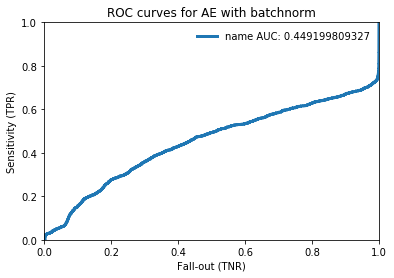

In [24]:
# Make ROC_curve

from sklearn.metrics import auc, roc_curve, roc_auc_score                          

def get_roc_curve(label, scores, names):
    """Generates ROC Curves for a given array"""
    fig, ax = plt.subplots()
    
    for i in range(len(scores)):
        fpr, tpr, thresholds = roc_curve(label, scores[i])
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr,
                 tpr,
                 linewidth=3,
                 #linestyle=line_styles[0],
                 label=("%s AUC: %s" % (names[i], roc_auc)))
        
    plt.legend(frameon=False)
    plt.ylabel("Sensitivity (TPR)")
    plt.xlabel("Fall-out (TNR)")
    plt.ylim([0, 1])
    plt.xlim([0, 1])
    plt.title('ROC curves for AE with batchnorm')
    plt.show();
    
get_roc_curve(y_test, [ae_error], ['name'])

In [64]:
# model_directory = "/afs/cern.ch/user/t/tkrzyzek/Documents/Data-Certification/temp/"

In [65]:
pickle.dump(ae_error, open(model_directory + "ae_error.p", "wb"))